In [ ]:
import ggml_ot

import requests
import anndata as ad
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# URL of the dataset
url = "https://datasets.cellxgene.cziscience.com/c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
destination_path = "data/czi_dataset.h5ad"

# create the directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# download and save the file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(destination_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Dataset downloaded and saved to: {destination_path}")

Dataset downloaded and saved to: data/czi_dataset.h5ad


In [3]:
# load anndata object into memory
destination_path = "data/czi_dataset.h5ad"

adata = ad.read_h5ad(destination_path)

In [ ]:
# load the dataset in "backed" mode. This way, not the whole dataset will be loaded into memory
# which can be useful for large datasets or little RAM.
# Note that in backed mode, only adata.X can be modified.
# When working with subsets of datasets, the parameter "n_cells" needs to be lowered
adata = ad.read_h5ad("data/czi_dataset.h5ad", backed='r')

# subsample dataset to 10,000 cells
n_cells = adata.n_obs
sample_size = 10000 # adjust as needed
if sample_size > n_cells:
    raise ValueError("Sample size is larger than total number of cells!")
idx = np.random.choice(n_cells, size=sample_size, replace=False)

# load only the subset into memory
adata_subset = adata[idx, :].to_memory()

# save the subsampled dataset for later use
adata_subset.write("data/subset_10000.h5ad")
local_path = "data/subset_10000.h5ad"


In [3]:
local_path = "data/czi_dataset.h5ad"
training_data = ggml_ot.scRNA_Dataset(local_path)

View of AnnData object with n_obs × n_vars = 191795 × 7777
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_original_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [5]:
train_dataset = DataLoader(training_data, batch_size=128, shuffle=True)

Running GGML with alpha: 10, lambda: 1, rank: 5


100%|██████████| 11/11 [10:02<00:00, 54.73s/it]


Iteration 1 with Loss  1132.7899169921875


100%|██████████| 11/11 [10:03<00:00, 54.82s/it]


Iteration 2 with Loss  784.5625


100%|██████████| 11/11 [10:27<00:00, 57.06s/it]


Iteration 3 with Loss  457.5306091308594


100%|██████████| 11/11 [10:19<00:00, 56.35s/it]


Iteration 4 with Loss  211.6412811279297


100%|██████████| 11/11 [10:01<00:00, 54.67s/it]


Iteration 5 with Loss  73.5269775390625
Compute all OT distances after 5 iterations


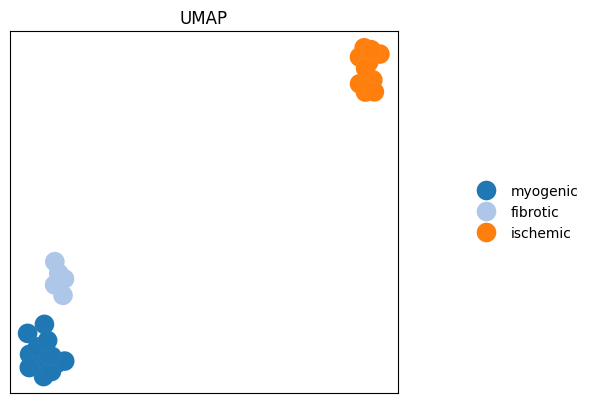

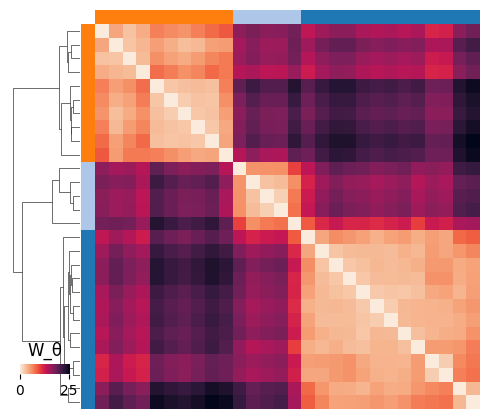

In [7]:
w_theta = ggml_ot.ggml(train_dataset,lr=0.02,l=1,max_iterations=5,plot_i_iterations=5,dataset=training_data)

For more detailed examples on plotting, see "synth_Test.ipynb"

PCA
(28, 1000, 7777)


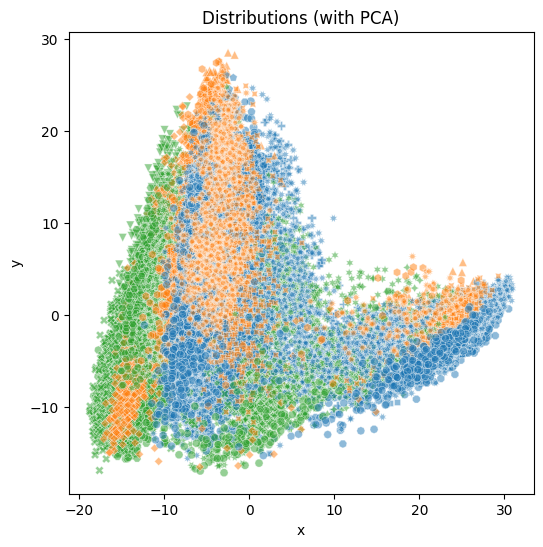

In [8]:
# plot distributions using PCA
a = training_data.distributions
b = training_data.distributions_labels
ggml_ot.plot_distribution(a, b, title = "Distributions (with PCA)", legend = False)
plt.show()

Text(0.5, 1.0, 'Euclidean and Mahalanobis')

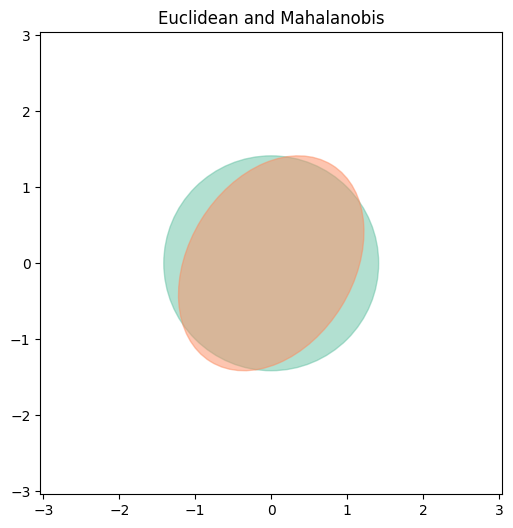

In [9]:
m = np.transpose(w_theta) @ w_theta  # Mahalanobis matrix

fig, axs = plt.subplots(figsize=(12, 6))

ax = ggml_ot.plot_ellipses([np.identity(2), m[:2, :2]], ax=axs)
ax.set_title(r'Euclidean and Mahalanobis')

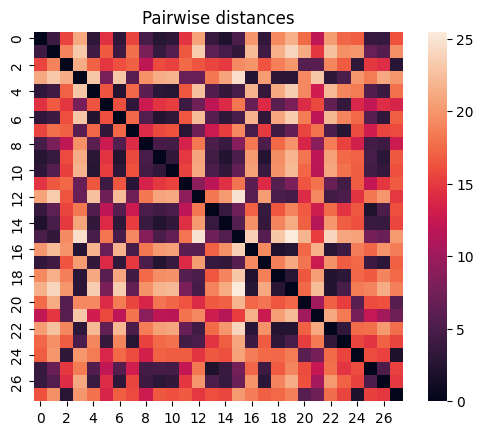

In [10]:
D_ggml = training_data.compute_OT_on_dists(w = w_theta, plot = False)
ggml_ot.plot_heatmap(D_ggml)

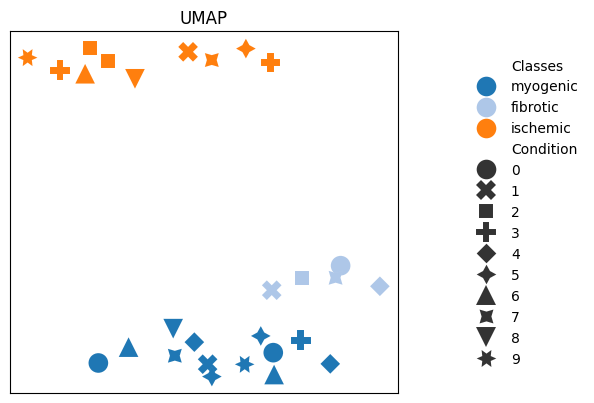

In [11]:
symbols = [i % 10 for i in range(len(training_data.distributions))]
colors = training_data.distributions_labels

emb = ggml_ot.plot_emb(D_ggml,method='umap',colors=training_data.disease_labels,symbols=symbols,legend="Side",title="UMAP",verbose=True,s=200)

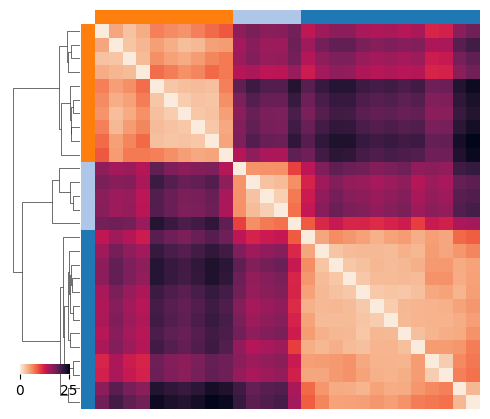

In [12]:
linkage = ggml_ot.plot_clustermap(D_ggml, training_data.distributions_labels)